# Conditioning
---
## Cognition and conditioning
We have built up a tool set for constructing probabilistic generative models. These can represent knowledge about causal processes in the world: running one of these programs generates a particular outcome by sampling a “history” for that outcome. However, the power of a causal model lies in the flexible ways it can be used to reason about the world. In the last chapter we ran generative models forward to reason about outcomes from initial conditions. Generative models also enable reasoning in other ways. For instance, if we have a generative model in which X is the output of a process that depends on Y (say `X = coolFunction(Y)`) we may ask: “assuming I have observed a certain X, what must Y have been?” That is we can reason backward from outcomes to initial conditions. More generally, we can make hypothetical assumptions and reason about the generative history: “assuming something, how did the generative model run?” In this section we describe how a wide variety of such hypothetical inferences can be made from a single generative model by conditioning the model on an assumed or observed fact.

Much of cognition can be understood in terms of conditional inference. In its most basic form, causal attribution is conditional inference: given some observed effects, what were the likely causes? Predictions are conditional inferences in the opposite direction: given that I have observed some cause, what are its likely effects? These inferences can be described by conditioning a probabilistic program that expresses a causal model. The acquisition of that causal model, or learning, is also conditional inference at a higher level of abstraction: given our general knowledge of how causal relations operate in the world, and some observed events in which candidate causes and effects co-occur in various ways, what specific causal relations are likely to hold between these observed variables?

To see how the same concepts apply in a domain that is not usually thought of as causal, consider language. The core questions of interest in the study of natural language are all at heart conditional inference problems. Given beliefs about the structure of my language, and an observed sentence, what should I believe about the syntactic structure of that sentence? This is the parsing problem. The complementary problem of speech production is related: given the structure of my language (and beliefs about others’ beliefs about that), and a particular thought I want to express, how should I encode the thought? Finally, the acquisition problem: given some data from a particular language, and perhaps general knowledge about universals of grammar, what should we believe about that language’s structure? This problem is simultaneously the problem facing the linguist and the child trying to learn a language.

Parallel problems of conditional inference arise in visual perception, social cognition, and virtually every other domain of cognition. In visual perception, we observe an image or image sequence that is the result of rendering a three-dimensional physical scene onto our two-dimensional retinas. A probabilistic program can model both the physical processes at work in the world that produce natural scenes, and the imaging processes (the “graphics”) that generate images from scenes. Perception can then be seen as conditioning this program on some observed output image and inferring the scenes most likely to have given rise to it.

When interacting with other people, we observe their actions, which result from a planning process, and often want to guess their desires, beliefs, emotions, or future actions. Planning can be modeled as a program that takes as input an agent’s mental states (beliefs, desires, etc.) and produces action sequences—for a rational agent, these will be actions that are likely to produce the agent’s desired states reliably and efficiently. A rational agent can plan their actions by conditional inference to infer what steps would be most likely to achieve their desired state. Action understanding, or interpreting an agent’s observed behavior, can be expressed as conditioning a planning program (a “theory of mind”) on observed actions to infer the mental states that most likely gave rise to those actions, and to predict how the agent is likely to act in the future.

### Reasoning with inference
Suppose that we know some fixed fact, and we wish to consider hypotheses about how a generative model could have given rise to that fact. using if statments, latent variables and infernce function we can describe the conditional distributions 

Consider the following simple generative model:

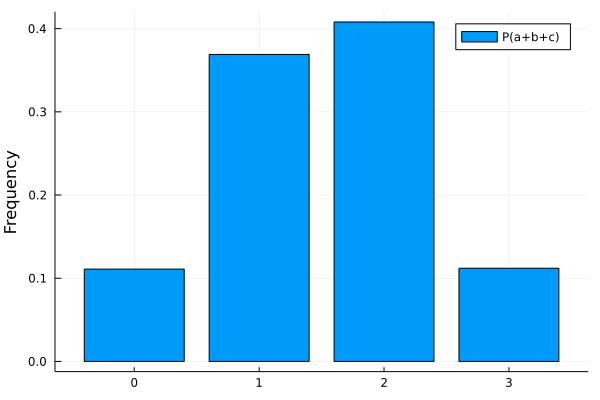

In [2]:
using Gen
include("auxilery.jl")
@gen function model()
    a=@trace(bernoulli(0.5),:a)
    b=@trace(bernoulli(0.5),:b)
    c=@trace(bernoulli(0.5),:c)
    d=a+b+c
end
ys=[get_retval(simulate(model,())) for _ in 1:1000]
viz(ys, "P(a+b+c)")

The process described in `model` samples three numbers and adds them (recall Julia converts booleans to 0 or 1 when they enter arithmetic). The value of the final expression here is 0, 1, 2 or 3. A priori, each of the variables `A`, `B`, `C` has .5 probability of being `1` or `0`. However, suppose that we know that the sum D is equal to 3. How does this change the space of possible values that variable `A` could have taken? `A` (and `B` and `C`) must be equal to 1 for this result to happen. We can see this in the following Julia inference, where we use a latent variable in the model and choicemap in the inference function to express the desired assumption:

In [4]:
function importence_resamplin_inference(model, var,value, amount_of_computation)
    
    # Create a choice map that maps model addresses - var 
    # to observed value - value. We leave other variables
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    observations[var] = value
           
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (), observations, amount_of_computation);
    return trace
end;

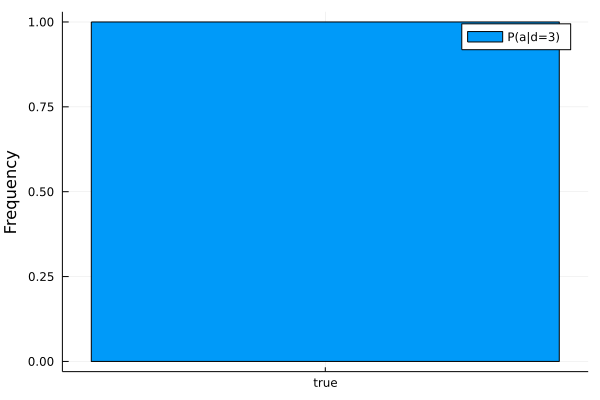

In [5]:
@gen function model2()
    a = @trace(bernoulli(0.5),:a)
    b = @trace(bernoulli(0.5),:b)
    c = @trace(bernoulli(0.5),:c)
    d = a+b+c
    if d == 3
        @trace(bernoulli(0.9999),:"d==3")
    else
        @trace(bernoulli(0.00001),:"d==3")    
    end
    d
end

ys=[]
for _ in 1:1000
    trace = importence_resamplin_inference(model2, "d==3",true, 100)
    push!(ys,trace[:a])
end
viz(ys,"P(a|d=3)")

The output of `importence_resamplin_inference` is a trace that describes appropriate beliefs about the likely value of `a`,`b`,`c` conditioned on `d` being equal to 3.

Now suppose that we condition on `d` being greater than or equal to 2. Then `a` need not be 1, but it is more likely than not to be. (Why?) The corresponding plot shows the appropriate distribution of beliefs for `A` conditioned on this new fact:

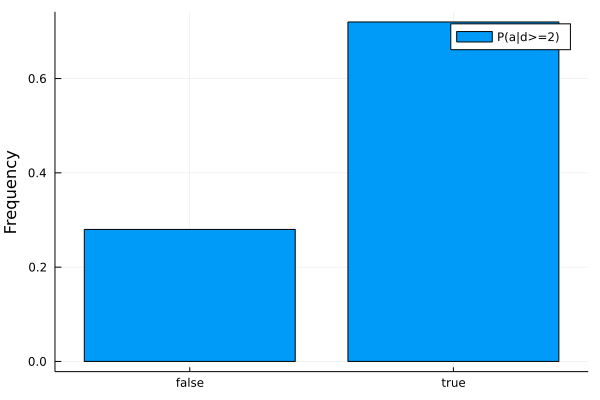

In [6]:
@gen function model3()
    a=@trace(bernoulli(0.5),:a)
    b=@trace(bernoulli(0.5),:b)
    c=@trace(bernoulli(0.5),:c)
    if a+b+c >= 2
        @trace(bernoulli(0.999),:"d>=2")
    else
        @trace(bernoulli(0.001),:"d>=2")
    end
end
ys=[]
for _ in 1:100
    trace=importence_resamplin_inference(model3, "d>=2",true, 100)
    push!(ys,trace[:a])
end
viz(ys,"P(a|d>=2)")

Going beyond the basic intuition of “hypothetical reasoning”,  infernce in the presence of condition can be understood in several, equivalent, ways. We focus on two: the process of rejection sampling, and the the mathematical formulation of a conditional distribution

### Rejection Sampling
How can we imagine answering a hypothetical such as those above? We have already seen how to get a sample from a generative model, without constraint, by simply running the evaluation process “forward” (i.e. simulating the process). We can get conditional samples by forward sampling the entire model, but only keeping the sample if the value passed to condition is true. For instance, to sample from the above model “a given that d is greater than 2” we could:

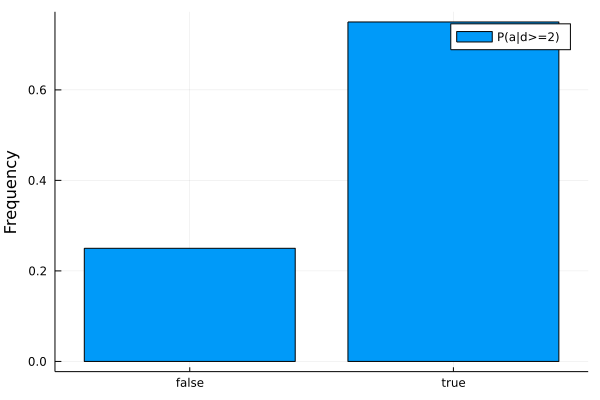

In [7]:
@gen function takeSample()
    a = @trace(bernoulli(0.5),:a)
    b = @trace(bernoulli(0.5),:b)
    c = @trace(bernoulli(0.5),:c)
    d = a+b+c
    d >=2 ? a : @trace(takeSample(), :t)
end
ys = [get_retval(simulate(takeSample,())) for _ in 1:100]
viz(ys,"P(a|d>=2)")

Notice that we have used a stochastic recursion to sample the model repeatedly until `d >= 2` is `true`, and we then return `a`: we generate and test until the condition is satisfied. This process is known as rejection sampling; we can use this technique to make a more general function that implements infernce using a predicat over the trace:

In [16]:
function  rejection_sampeling(model,args,pred)
    trace=simulate(model,args)
    while(!pred(trace))
        trace=simulate(model,args)
    end
    trace
end

rejection_sampeling (generic function with 1 method)

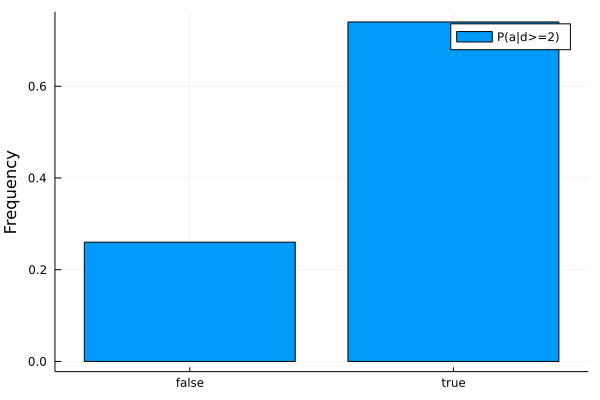

In [20]:
N=100
ys=[rejection_sampeling(model3,(),x -> x["d>=2"]) for _ in 1:N]

viz(map(x-> x[:a],ys),"P(a|d>=2)")

##Conditional Distributions
The formal definition of conditional probability in probability theory is:
$$P(A=a∣B=b)=\frac{P(A=a,B=b)}{P(B=b)}$$
Here $P(A=a∣B=b)$ is the probability that “event” A has value a given that B has value b. (The meaning of events A and B must be given elsewhere in this notation, unlike a Gen generative function, which contains the full model specification, conditioning is done in the inference function) The joint probability, $P(A=a,B=b)$, is the probability that A has value a and B has value b. So the conditional probability is simply the ratio of the joint probability to the probability of the condition.

In the case of a Gen infernce with a obseravtion, $A=a$ will be the “event” that $A = a$, while $B = b$ will be the event that the value passed to obseravtion is true (so b is True). Because each of these is a regular (unconditional) probability, they and their ratio can often be computed exactly using the rules of probability. we will implement infernce base on that (by first enumerating all the possible executions of the model):

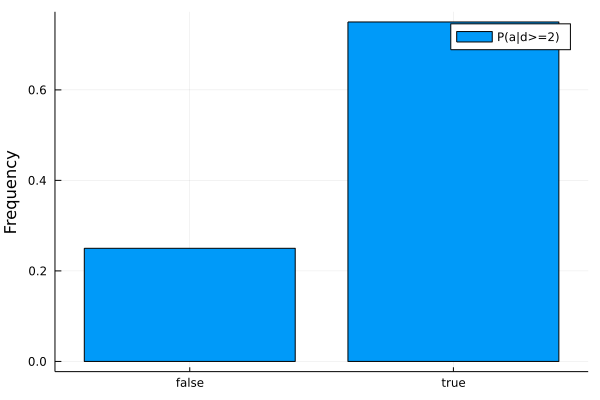

In [22]:
##inference by enumeration function for 3 i.i.d. bernoulli variables a,b,c
function enumeration_infernce(model,args,var)
    support=[true,false]
    results = []
    trace = simulate(model,args)
    for (a1,b1,c1) in Iterators.product(support,support,support)        
        constraints  = Gen.choicemap((:a, a1),(:b, b1),(:c, c1))        
        (trace, w) = generate(model, (), constraints)
        if trace["d>=2"]
            push!(results,trace[var])
        end
    end
    return results
end

ys=enumeration_infernce(model3,(),:a)
viz(ys,"P(a|d>=2)")       
        

### Connection to rejection sampling
The above notion of conditional distribution in terms of rejection sampling is equivalent to the mathematical definition, when both are well-defined. (There are special cases when only one definition makes sense. For instance, when continuous random choices are used it is possible to find situations where rejection sampling almost never returns a sample but the conditional distribution is still well defined. Why?)

Indeed, we can use the process of rejection sampling to understand this alternative definition of the conditional probability $P(A=a∣B=b)$. Imagine that we have sampled $N_{total}$ times. We only keep those samples in which the condition is true, say there are $N_{B=True}$ of them. Of these some number $N_{A=a,B=True}$ have the returned value a. The ratio 
$$\frac{N_{A=a,B=True}}{N_{B=True}}=\frac{\frac{N_{A=a,B=True}}{N_{total}}}{\frac{N_{B=True}}{N_{total}}}$$
is the fraction of times that $$ when $B=True$. When the number of samples is very large this converges to $\frac{P(A=a,B=True)}{P(B=True)}$. Thus the rejection sampling definition of conditional probability implies the above (probability ratio) definition.

Try using the formula for conditional probability to compute the probability of the different return values in the above examples. Check that you get the same probability that you observe when using rejection sampling.

### Bayes Rule
One of the most famous rules of probability is Bayes’ rule, which states:

$$P(h∣d)=\frac{P(d∣h)P(h)}{P(d)}$$
It is first worth noting that this follows immediately from the definition of conditional probability:

$$P(h∣d)=\frac{P(d,h)}{P(d)}=\frac{P(d,h)P(h)}{P(d)P(h)}=\frac{P(d∣h)P(h)}{P(d)}$$
Next we can ask what this rule means in terms of sampling processes. Consider the program:

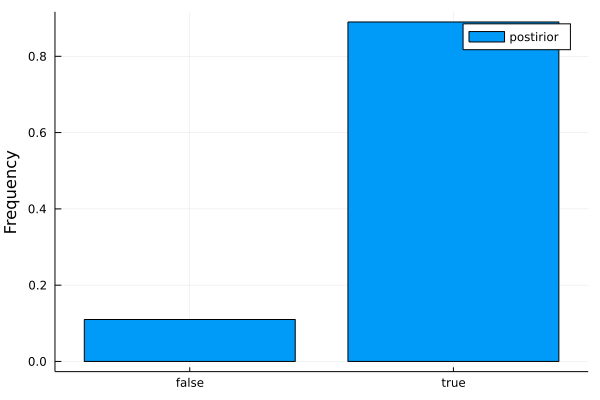

In [23]:

@gen function model4()
    hypothesis = @trace(bernoulli(0.5), :hypothesis) #prior  
    if hypothesis #adding noise
        data = @trace(bernoulli(0.9),:data) 
    else
        data = @trace(bernoulli(0.1),:data)
    end    
end

ys=[]
for _ in 1:100
    trace=importence_resamplin_inference(model4, :data,true, 100)
    push!(ys,trace[:hypothesis])
end
viz(ys,hcat("postirior"))

we have generated a value, the hypothesis, from some distribution called the prior, then added noise to get the observed data, the probability of such an observation function is usually called the likelihood. AfterwardsFinally we have returned the hypothesis, conditioned on the observation being equal to some observed data—this conditional distribution is called the posterior. This is a typical setup in which Bayes’ rule is used.

Bayes’ rule simply says that, in special situations where the model decomposes nicely into a part “before” the value to be returned (hypothesis) and a part “after” the value to be returned, then the conditional probability can be expressed simply in terms of the prior and likelihood components of the model. This is often a useful way to think about conditional inference in simple settings. However, we will see examples as we go along where Bayes’ rule doesn’t apply in a simple way, but the conditional distribution is equally well understood in other terms.

### Conditions and observations
A very common pattern is to condition directly on the value of a sample from some distribution. For instance here we try to recover a true number from a noisy observation of it:

In [26]:
@gen function model5()
    trueX = @trace(normal(0,1),:trueX)
    obsX = @trace(normal(trueX,0.1),:obsX)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##model5#272", Bool[], false)

In [203]:
sample=rejection_sampeling(model5,x -> x[:obsX]==0.2)


You will note that this never finishes. (Why? Think about what rejection sampling tries to do here….) In Gen we use choicemap,  to express the pattern of conditioning on a value sampled directly from a distribution. it is clearer. well look at the importance resampeling inference agian

In [91]:
function importence_resamplin_inference(model, vars,values, amount_of_computation)
    
    # Create a choice map that maps model addresses - var 
    # to observed value - value. We leave other variables
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    iterable= zip
    for (var,value) in zip(vars,values)        
        observations[var] = value
    end
           
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (), observations, amount_of_computation);
    return trace
end;

as we can see we fist get the the observables vars and their values and then we resample the model given these obesrvation

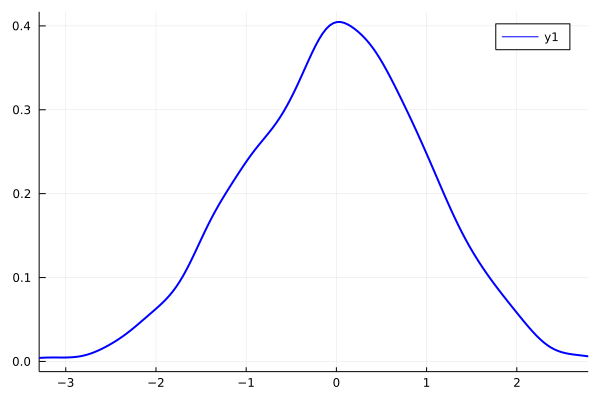

In [51]:
traces=[simulate(model5,()) for _ in 1:1000]
ret_values=map(x -> Gen.get_retval(x),traces)
plot(ret_values, seriestype = :density, xlim = (minimum(ret_values),maximum(ret_values)), legend = :best, w = 2, c = :blue)


It is natural and common to condition a generative model on a value for one of the variables declared in this model (i.e. to observe its value).one may wish to ask for more complex hypotheticals: “what if P,” where P is a complex proposition composed out of variables declared in the model. a relevent example is model3 where we express ?????

### Factors
Factor is like making a soft assumption that is merely preferred to be true. For instance, suppose we flip a single coin(sample a fair bernoulli rv). If we obsrve on the outcome being true, then the outcome must be true:

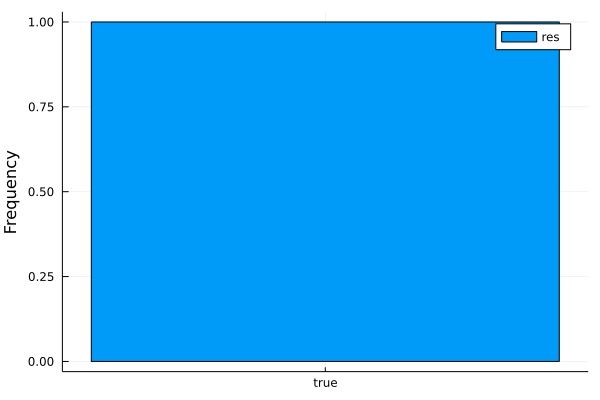

In [114]:
@gen function ber()
    @trace(bernoulli(0.5),:res)
end
obervation=choicemap((:res, true))
ys=[]
for _ in 1:100
    (trace, _) =generate(ber,(),obervation)
    push!(ys,get_retval(trace))
end
viz(ys,"res")

However, if we swap condition for factor, we simply make heads more likely:

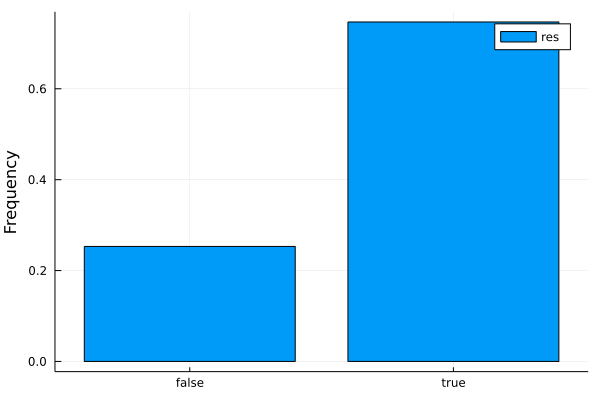

In [201]:
@gen function factor(x)
    @trace(bernoulli(exp(x)), :factor_x)
end
@gen function ber()
    res=@trace(bernoulli(0.5),:res)
    @trace(factor(res))
    res
end
ys=[]
for _ in 1:1000
    trace=importence_resamplin_inference(ber, [:factor_x],[true], 100)
    push!(ys,trace[:res])
end
viz(ys,"res")

Technically, `factor(x)` adds x to the unnormalized log-probability of the program execution within which it occurs. Thus, to get the new probabilities induced by the factor statement we compute the normalizing constant given these log-scores. The resulting probability $P(A=true)$ is:

$$P(A=true)=\frac{e^1}{e^0+e^1}$$
Play with this example. Can you revise the example to increase the probability of heads?

The factor construct is very general. Both condition and observe can be written easily in terms of factor. However models are often clearer when written with the more specialized forms. In machine learning it is common to talk of directed and undirected generative models; directed models can be thought of as those made from only sample and observe, while undirected models include factor (and often have only factors).

### Example: Reasoning about Tug of War
Imagine a game of tug of war, where each person may be strong or weak, and may be lazy or not on each match. If a person is lazy they only pull with half their strength. The team that pulls hardest will win. We assume that strength is a continuous property of an individual, and that on any match, each person has a 1 in 3 chance of being lazy. This Julia and Gen code runs a tournament between several teams, mixing up players across teams. Can you guess who is strong or weak, looking at the tournament results?

In [60]:
using Memoization
@gen function strength1(person)
  sampled_strength=@trace(normal(1,1), :sampled_strength)  
  @memoize func(y) = (println("Computed $x,$y"); (x,y))
end
 strength1(person) = @memoize strength1(person)
 @gen function lazy(person)
     @trace(bernoulli(1/3),:lazy)
 end
 @gen function pulling(person)
   @trace(lazy(person)) ? strength(person) / 2 : strength(person) 
 end
 
 println(strength("bob"))
 println(strength("bob"))
 pulling("bob")
# function totalPulling(team)
#   vec_pulling=Map(pulling)
#   sum(vec_pulling(team))
# end
# function winner(team1, team2)
#   totalPulling(team1) > totalPulling(team2) ? team1 : team2
# end
# print([
#     winner(["alice", "bob"], ["sue", "tom"]),
#     winner(["alice", "bob"], ["sue", "tom"]),
#     winner(["alice", "sue"], ["bob", "tom"]),
#     winner(["alice", "sue"], ["bob", "tom"]),
#     winner(["alice", "tom"], ["bob", "sue"]),
#     winner(["alice", "tom"], ["bob", "sue"])
#])

LoadError: LoadError: @memoize must be applied to a method definition
in expression starting at In[60]:6